## Recurrent Neural Networks in PyTorch

The Recurrent Neural Network (RNN) Architecture, which can actually be seen as a strict generalization of standard MLPs is, alongside Convolutional Neural Networks, one of the classic Architectures of Neural Networks. 

In some sense, RNN's introduce a time component into the Neural Network by not needed to compute data in a single forward pass. For a basic Introduction see https://en.wikipedia.org/wiki/Recurrent_neural_network.

They also have many interesting Theoretical properties, like being able to model any Computable function :O  which we will not focus on. Because it is so widely used, there already exists a PyTorch implementation. 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

In [2]:
class basicRNN(nn.Module):
    def __init__(self, hidden_dim, input_dim, output_dim):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.act_hidden = nn.Tanh()
                
        self.in_hidden = nn.Parameter(torch.randn(hidden_dim,input_dim))
        self.hidden_hidden = nn.Parameter(torch.randn(hidden_dim,hidden_dim))
        self.hidden_out = nn.Parameter(torch.randn(output_dim,hidden_dim))
    
    def forward(self, x, h_t = None): 
        if h_t is None: 
            h_t = torch.zeros(self.hidden_dim) 
        
        out = []
        for t in range(x.size(0)):
            x_t = x[t] # value at current time-step
            h_next = self.act_hidden(self.in_hidden @ x_t + self.hidden_hidden @ h_t)
            y = self.hidden_out @ h_next
            out.append(y)
        out = torch.stack(out, dim = 0)
        return out, h_next               

### Training a Recurrent Neural Network

RNN's are particularly strong on tasks involving time, or other sequential data like text. We will give an example how one can train an RNN on time-series data, namely some stock ticker. For that, we will use the `yfinance` library https://pypi.org/project/yfinance/. Firstly, we will have to transform our our time-series we are given by `yfinance` into a suitable dataset with lables.

In [3]:
def create_dataset(time_series, seq_length):
        x,y = [], []
        for i in range(len(time_series)-seq_length):
            x.append(time_series[i:i+seq_length])
            y.append(time_series[i+seq_length])
        return torch.tensor(np.array(x), dtype=torch.float32), torch.tensor(np.array(y), dtype=torch.float32)
    
ticker = "AAPL" 
start = "2023-01-01"
end = "2025-01-01"
data = yf.download(ticker, start, end)
#Lets only look at the closing prices at the end of each day 
data = data["Close"].values
data = (data - np.min(data)) / (np.max(data) - np.min(data))  # Normalize our data for stability

#seqlength is essentially the amount of time-steps we look at in each iteration, this directly corresponds to the hidden_dims as our hidden state
seq_length = 25
inputs, labels = create_dataset(data, seq_length)


split_size = int(len(inputs) * 0.9)
inputs_train, inputs_test = inputs[:split_size], inputs[split_size:]
labels_train, labels_test = labels[:split_size], labels[split_size:]


hidden_dim = 25
#now lets define our model
model = basicRNN(1, hidden_dim,1)
lossfunction = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr = 0.01)

#Now, lets train our model
iterations = 5000
h_t = torch.zeros(hidden_dim)
for epoch in range(iterations):
    model.zero_grad()
    
    ouputs, _ = model(inputs_train.unsqueeze(-1))
    loss = lossfunction(ouputs.squeeze(), labels_train)
    
    loss.backward()
    optimizer.step()    
    
    if epoch % 1000 == 0:
        print(f"The loss in Epoch {epoch} is {loss}")

[*********************100%***********************]  1 of 1 completed


The loss in Epoch 0 is 0.47444266080856323
The loss in Epoch 1000 is 0.0037299671676009893
The loss in Epoch 2000 is 0.0019019535975530744
The loss in Epoch 3000 is 0.0008765264065004885
The loss in Epoch 4000 is 0.0005645767087116838


We got an average loss of 0.013000283390283585 on our test set.


c:\Users\JoCraft\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([48])) that is different to the input size (torch.Size([48, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


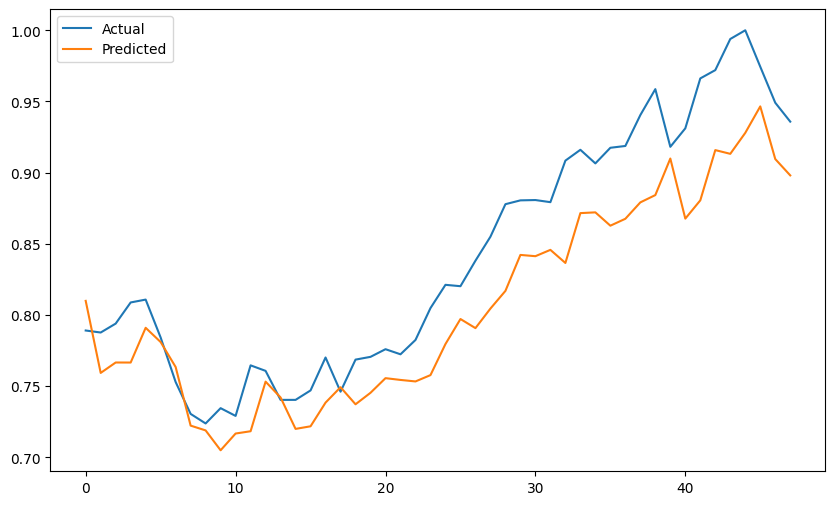

In [4]:
test_loss = 0
outputs, _  = model(inputs_test) 
test_loss =  lossfunction(outputs ,labels_test)
    
print(f"We got an average loss of {test_loss} on our test set.")


plt.figure(figsize=(10, 6))
plt.plot(range(len(labels_test)), labels_test.numpy(), label="Actual")
plt.plot(range(len(outputs)), outputs.detach().numpy().squeeze(), label="Predicted")
plt.legend()
plt.show()